In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import optuna
from numpy.linalg import norm
from functools import partial
from scipy.stats import pearsonr

from sklearn.model_selection import TimeSeriesSplit

SEED = 42
random.seed(SEED)
np.random.seed(SEED)           

# Dataset generation

In [24]:
def generate_machen(length, dt=0.01, alpha=3, beta=0.1, gamma=1,noise=0.0, seed=42, initial_state=None):
    
    """
    Generate a trajectory of the Ma-Chen financial system.

    Args:
        length         (int):      Number of time steps to generate.
        dt             (float):    Time step size.
        alpha          (float):    Parameter alpha (savings rate).
        beta           (float):    Parameter beta (investment cost).
        gamma          (float):    Parameter gamma (demand elasticity).
        noise          (float):    Std-dev of additive Gaussian noise on each variable.
        seed           (int/None): Random seed for reproducibility.
        initial_state  (array-like or None): Initial (u1, u2, u3). Random if None.

    Returns:
        t -> time vector
        traj -> the Ma–Chen system trajectory at each time.
    """
    rng = np.random.default_rng(seed)
    
    # Initialize state
    if initial_state is None:
        state = rng.standard_normal(3)
    else:
        state = np.array(initial_state, dtype=float)
    
    t = np.linspace(0, dt*(length-1), length)
    traj = np.zeros((length, 3))
    traj[0] = state

    def machen_rhs(s, alpha=3, beta=0.1, gamma=1):
        u1, u2, u3 = s
        du1 = u3 + (u2 - alpha) * u1
        du2 = 1 - beta * u2 - u1**2
        du3 = -u1 - gamma * u3
        return np.array([du1, du2, du3])

    for i in range(1, length):
        s = traj[i-1]
        k1 = machen_rhs(s)
        k2 = machen_rhs(s + 0.5 * dt * k1)
        k3 = machen_rhs(s + 0.5 * dt * k2)
        k4 = machen_rhs(s + dt * k3)
        traj[i] = s + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    # Add Gaussian noise if requested on measurements
    if noise > 0:
        traj += rng.normal(scale=noise, size=traj.shape)

    return t, traj


def machen_rhs(state, alpha=3, beta=0.1, gamma=1):
   
    state = np.asarray(state)
    if state.ndim == 2:
        u1 = state[:, 0]
        u2 = state[:, 1]
        u3 = state[:, 2]
        du1 = u3 + (u2 - alpha) * u1
        du2 = 1 - beta * u2 - u1**2
        du3 = -u1 - gamma * u3
        return np.stack((du1, du2, du3), axis=1)

    u1, u2, u3 = state
    du1 = u3 + (u2 - alpha) * u1
    du2 = 1 - beta * u2 - u1**2
    du3 = -u1 - gamma * u3
    return np.array([du1, du2, du3])


def nrmse(y_true, y_pred):
    
    num = np.linalg.norm(y_true - y_pred)
    den = np.linalg.norm(y_true)
    return num / den


def split_train_val_test(u, y, train_frac=0.6, val_frac=0.2):
    
    if train_frac + val_frac >= 1.0:
        raise ValueError("train_frac + val_frac must be < 1.0")
    N = len(u)
    i_train = int(train_frac * N)
    i_val   = i_train + int(val_frac * N)

    return ((u[:i_train], y[:i_train]), (u[i_train:i_val], y[i_train:i_val]), (u[i_val:], y[i_val:]))

## ESN and PI-ESN Class

In [25]:
class ESN:
    def __init__(
        self,
        in_size: int,
        res_size: int,
        out_size: int,
        spectral_radius: float = 0.95,
        sparsity: float = 0.1,
        input_scaling: float = 1.0,
        leak_rate: float = 1.0,
        ridge_reg: float = 1e-8,
        seed: int = SEED,
        topology: str = "random"
    ):
        
        self.in_size = in_size
        self.res_size = res_size
        self.out_size = out_size
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.input_scaling = input_scaling
        self.leak_rate = leak_rate
        self.ridge_reg = ridge_reg
        self.topology = topology

        self.rng = np.random.default_rng(seed)
        self.Wout = None  # verrà settato in fit()

        # Genera Win e W
        self._init_weights()

    def _init_weights(self):
        """Crea Win e W, quindi scala W per avere lo spectral radius desiderato."""
        N = self.res_size
        # Win: (res_size, in_size+1)
        self.Win = (np.random.rand(self.res_size, self.in_size + 1) - 0.5) * 2 * self.input_scaling

        if self.topology == "random":
            W = self.rng.random((N, N)) - 0.5
            mask = self.rng.random((N, N)) < self.sparsity
            W[mask] = 0.0
        elif self.topology == "ring":
            W = np.zeros((N, N))
            for i in range(N):
                W[i, (i+1) % N] = self.rng.uniform(-0.5, 0.5)
                W[i, (i-1) % N] = self.rng.uniform(-0.5, 0.5)
        elif self.topology == "double_cycle":
            if N % 2 != 0:
                raise ValueError("double_cycle richiede res_size pari")
            W = np.zeros((N, N))
            half = N // 2
            for i in range(N):
                W[i, (i+1) % N]    = self.rng.uniform(-0.5, 0.5)
                W[i, (i-1) % N]    = self.rng.uniform(-0.5, 0.5)
                W[i, (i+half) % N] = self.rng.uniform(-0.5, 0.5)
                W[i, (i-half) % N] = self.rng.uniform(-0.5, 0.5)
        else:
            raise ValueError(f"Topologia '{self.topology}' non riconosciuta")

        eigs = np.linalg.eigvals(W)
        radius = np.max(np.abs(eigs))
        self.W = W * (self.spectral_radius / radius)

    def _update(self, state: np.ndarray, u: np.ndarray) -> np.ndarray:
        #One-step reservoir update (leaky integrator): x' = (1 - α)*x + α * tanh( Win·[1; u] + W·x ).

        u_aug = np.hstack(([1.0], u))  # (in_size + 1,)
        preact = self.Win.dot(u_aug) + self.W.dot(state)
        x_new = (1 - self.leak_rate) * state + self.leak_rate * np.tanh(preact)
        return x_new

    def fit(self, U: np.ndarray, Y: np.ndarray, washout: int = 100):
        """
        Allena la readout Wout tramite ridge-regression.
        U: array di shape (T, in_size) oppure (T,) se in_size=1
        Y: array di shape (T, out_size)
        """
        T = U.shape[0]
        Nf = self.res_size + self.in_size + 1

        # Prealloca X (da washout in poi) e Y_target
        X = np.zeros((T - washout, Nf))
        Y_target = Y[washout:]  # (T-washout, out_size)

        x = np.zeros(self.res_size)
        for t in range(T):
            # garantiamo che U[t] diventi array 1D di lunghezza in_size
            u = np.atleast_1d(U[t])
            x = self._update(x, u)
            if t >= washout:
                feat = np.hstack(([1.0], u, x))
                X[t - washout] = feat

        # Ridge regression chiude-forma
        XtX = X.T.dot(X)
        reg_mat = self.ridge_reg * np.eye(XtX.shape[0])
        Wtilde = np.linalg.inv(XtX + reg_mat)
        self.Wout = Y_target.T.dot(X).dot(Wtilde)  # (out_size, n_features)

    def predict(self, U: np.ndarray, continuation: bool = False) -> np.ndarray:
        """
        Predice la sequenza di output dato l'input U.
        U: (T, in_size) o (T,) se in_size=1.
        Se continuation=True, parte dallo stato di reservoir salvato.
        """
        T = U.shape[0]
        Y_hat = np.zeros((T, self.out_size))

        if continuation and hasattr(self, 'last_state'):
            x = self.last_state.copy()
        else:
            x = np.zeros(self.res_size)

        for t in range(T):
            u = np.atleast_1d(U[t])
            x = self._update(x, u)
            feat = np.hstack(([1.0], u, x))
            Y_hat[t] = self.Wout.dot(feat)

        self.last_state = x.copy()
        return Y_hat

In [26]:
class PIESN(ESN):
    
    def __init__(
        self,
        in_size: int,
        res_size: int,
        out_size: int,
        spectral_radius: float = 0.95,
        sparsity: float = 0.1,
        input_scaling: float = 1.0,
        leak_rate: float = 1.0,
        ridge_reg: float = 1e-8,
        seed: int = SEED,
        topology: str = "random",
        lambda_data: float = 1.0,
        lambda_phys: float = 0.01,
        ode_func=None,
        delta_t: float = 0.01,
        phys_horizon: int = 10,
        full_closed_loop: bool = False,
        curriculum: bool = False,
        curr_tau: float = 10.0
    ):
        super().__init__(
            in_size        = in_size,
            res_size       = res_size,
            out_size       = out_size,
            spectral_radius= spectral_radius,
            sparsity       = sparsity,
            input_scaling  = input_scaling,
            leak_rate      = leak_rate,
            ridge_reg      = ridge_reg,
            seed           = seed,
            topology       = topology
        )
        self.lambda_data      = lambda_data
        self.lambda_phys      = lambda_phys
        self.ode_func         = ode_func
        self.delta_t          = delta_t
        self.phys_horizon     = phys_horizon
        self.full_closed_loop = full_closed_loop
        self.curriculum       = curriculum
        self.curr_tau         = curr_tau
        self.curr_step        = 0

        self._mean_U = None  
        self._std_U  = None  

        # Stato del reservoir da ereditare se continuation=True
        self.last_state = None

    def _compute_data_loss(self, W_flat, X, Y_target):
        #Data‐loss = MSE + ridge_reg * ||Wout||^2
        
        Wout = W_flat.reshape(self.out_size, self.res_size)  # (out_size, res_size)
        Y_pred = X.dot(Wout.T)                               # (T-washout, out_size)
        mse    = np.mean((Y_pred - Y_target) ** 2)
        reg    = self.ridge_reg * np.sum(Wout ** 2)
        return mse + reg

    def _compute_physics_loss(self, W_flat, Y0 ,U_seq):
        #Physics-loss su phys_horizon passi futuri:
        
        N    = self.phys_horizon
        Wout = W_flat.reshape(self.out_size, self.res_size)  # (out_size, res_size)
        x    = np.zeros(self.res_size)
        Y_pred = [Y0.copy()]  # lista di vettori (out_size,)

        for n in range(N):
            u = np.atleast_1d(U_seq[n])       # (in_size,)
            feat = x                         # (res_size,) → solo reservoir
            y_next = Wout.dot(feat)          # (out_size,)
            Y_pred.append(y_next)

            if self.full_closed_loop:
                x = self._update(x, y_next)
            else:
                x = self._update(x, u)

        Y_pred = np.stack(Y_pred)             # (N+1, out_size)
        dY     = (Y_pred[1:] - Y_pred[:-1]) / self.delta_t  # (N, out_size)

        try:
            F = self.ode_func(Y_pred[:-1])    # (N, out_size)
        except:
            F = np.vstack([self.ode_func(y) for y in Y_pred[:-1]])

        res = dY - F                          # (N, out_size)
        phys_loss = np.mean(res ** 2)

        if self.curriculum: #Se curriculum=True, moltiplica per curr_factor
            curr_factor = 1 - np.exp(- self.curr_step / self.curr_tau)
            self.curr_step += 1
        else:
            curr_factor = 1.0

        return curr_factor * phys_loss

    def _total_loss(self, W_flat, X, Y_target, Y0, U_seq):
          #L = lambda_data * Ld + lambda_phys * Lp

        Ld = self._compute_data_loss(W_flat, X, Y_target)
        Lp = self._compute_physics_loss(W_flat, Y0, U_seq)
        return self.lambda_data * Ld + self.lambda_phys * Lp

    def fit_physics(self, U, Y, washout = 100):

        """
        Esegue addestramento PI-ESN:
          1. Normalizza (U,Y) con Z-score
          2. Propaga reservoir su U_norm per raccogliere tutti gli stati (states)
          3. Costruisce X = states[washout:]  e Y_target = Y_norm[washout:]
             ⇒ X ha shape (T-washout, res_size)
          4. Risolve regressione ridge iniziale su (X, Y_target)
             ⇒ W0 piatto di shape (out_size * res_size)
          5. Minimizza L = data_loss + physics_loss con L-BFGS-B
        Ritorna OptimizeResult di SciPy.
        """
        T = U.shape[0]
        N = self.phys_horizon

        # 1) Normalizzazione Z‐score
        mean_U = U.mean(axis=0)          # (in_size,)
        std_U  = U.std(axis=0) + 1e-8
        U_norm = (U - mean_U) / std_U     # (T, in_size)
        Y_norm = (Y - mean_U) / std_U     # (T, out_size)

        self._mean_U = mean_U.copy()
        self._std_U  = std_U.copy()

        # Propago il reservoir e salvo gli stati in “states”
        x_state = np.zeros(self.res_size)
        states = np.zeros((T, self.res_size))  # (T, res_size)
        for t_i in range(T):
            u_i = np.atleast_1d(U_norm[t_i])   # (in_size,)
            x_state = self._update(x_state, u_i)
            states[t_i] = x_state

        # Costruisco X, Y_target dopo washout
        X = states[washout:]           # (T-washout, res_size)
        Y_target = Y_norm[washout:]    # (T-washout, out_size)

        # Verifica condizione physics horizon
        if T < washout + 2 * N:
            raise ValueError("Serve T >= washout + 2 * phys_horizon")

        # Preparo Y0 e U_seq normalizzati per physics_loss
        idx0 = washout + N
        Y0   = Y_norm[idx0]                 # (out_size,)
        U_seq = U_norm[idx0 : idx0 + N]      # (N, in_size)

        # Soluzione iniziale ridge-only (X, Y_target)
        XtX = X.T.dot(X)                     # (res_size, res_size)
        reg_mat = self.ridge_reg * np.eye(self.res_size)
        W_ridge = np.linalg.solve(XtX + reg_mat, X.T.dot(Y_target))
        # W_ridge ha shape (res_size, out_size)
        W0 = W_ridge.T.flatten()             # (out_size * res_size,)

        # Minimizzazione loss totale con L-BFGS-B
        self.curr_step = 0
        result = minimize(
            fun    = self._total_loss,
            x0     = W0,
            args   = (X, Y_target, Y0, U_seq),
            method = 'L-BFGS-B'
        )

        W_opt = result.x.reshape(self.out_size, self.res_size)  # (out_size, res_size)
        self.Wout = W_opt.copy()
        return result

    def predict(self,U, continuation = False):
        """
        1. Normalizza U usando (mean_U, std_U)
        2. Propaga reservoir e raccoglie gli stati x_t
        3. Calcola Y_hat_norm[t] = Wout ⋅ x_t
        4. De-normalizza: Y_hat = Y_hat_norm * std_U + mean_U
        5. Se continuation=True, eredita last_state
        """
        U_norm = (U - self._mean_U) / self._std_U  # (T_te, in_size)
        T = U_norm.shape[0]
        Y_hat_norm = np.zeros((T, self.out_size))  # (T_te, out_size)

        if continuation and hasattr(self, "last_state"):
            x = self.last_state.copy()
        else:
            x = np.zeros(self.res_size)

        for t_i in range(T):
            u_i = np.atleast_1d(U_norm[t_i])
            x = self._update(x, u_i)           # (res_size,)
            Y_hat_norm[t_i] = self.Wout.dot(x) # (out_size,)

        self.last_state = x.copy()
        return (Y_hat_norm * self._std_U) + self._mean_U

In [27]:
def objective(trial):
    params = {
        "in_size":         3,
        "out_size":        3,
        "res_size":       trial.suggest_int("res_size",      256, 1024, step=2),
        "spectral_radius":trial.suggest_float("rho",        0.1, 0.3, log=True),
        "sparsity":       trial.suggest_float("sparsity",   0.01, 0.05, log=True),
        "input_scaling":  trial.suggest_float("in_scale",   0.1, 1.0),
        "leak_rate":      trial.suggest_float("alpha",      0.2, 0.5),
        "ridge_reg":      trial.suggest_float("ridge_reg",  1e-6, 1e-3, log=True),
        "topology":       trial.suggest_categorical("topo",   ["random","ring","double_cycle"]),
        # pesi fisica vs dati
        "lambda_data":    trial.suggest_float("λ_data",     0.5, 3.0, log=True),
        "lambda_phys":    trial.suggest_float("λ_phys",     1e-2, 0.5, log=True),
        "phys_horizon":   trial.suggest_int("horizon",      3,   7),
    }

    fold_scores = []
    for train_idx, val_idx in tscv.split(U):
        u_tr,  u_val  = U[train_idx],  U[val_idx]
        y_tr,  y_val  = Y[train_idx],  Y[val_idx]

        piesn = PIESN(
            **params,
            seed=SEED,
            ode_func=lorenz_rhs,
            delta_t=dt,
            full_closed_loop=True,
            curriculum=True,
            curr_tau=10.0
        )

        piesn.fit_physics(u_tr, y_tr, washout=100)

        y_val_pred = piesn.predict(u_val, continuation=False)

        score = nrmse_multi(y_val[100:], y_val_pred[100:])
        fold_scores.append(score)

    return float(np.mean(fold_scores))

In [28]:
#gia allenato il modello con optuna

In [29]:
best = {
    'res_size': 960,
    'rho': 0.10009762488352285,
    'sparsity': 0.014635603653829913,
    'in_scale': 0.10012333896882074,
    'alpha': 0.22320271024144345,
    'ridge_reg': 8.160533191764472e-05,
    'topo': 'random',
    'λ_data': 0.736548536623833,
    'λ_phys': 0.13714180027119693,
    'horizon': 7
}
# Best CV NRMSE: 0.006060125647370649

dt = 0.01
length = 10000

alpha = 3
beta = 0.1
gamma = 1
noise_levels = [1, 2, 3, 4, 5]
results = []


for noise in noise_levels:
   
    np.random.seed(SEED)
    t, traj_noisy = generate_machen(length=length, dt=dt, noise=noise)

    U_noisy = traj_noisy[:-1]   
    Y_noisy = traj_noisy[1:]    
    (u_tr, y_tr), (u_val, y_val), (u_te, y_te) = split_train_val_test(U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2)


    ode_wrapped = partial(machen_rhs, alpha=alpha, beta=beta, gamma=gamma)

    piesn_final = PIESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo'],
        lambda_data=best['λ_data'],
        lambda_phys=best['λ_phys'],
        ode_func=ode_wrapped,        # il wrapper che include già alpha,beta,gamma
        delta_t=dt,
        phys_horizon=best['horizon'],
        full_closed_loop=True,
        curriculum=True,
        curr_tau=10.0
    )
    piesn_final.fit_physics(u_tr, y_tr, washout=100)
    y_pred_piesn = piesn_final.predict(u_te, continuation=False)
    nrmse_piesn = norm(y_te[100:] - y_pred_piesn[100:]) / norm(y_te[100:])

    esn_only = ESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo']
    )
    esn_only.fit(u_tr, y_tr, washout=100)
    y_pred_esn = esn_only.predict(u_te, continuation=False)
    nrmse_esn = norm(y_te[100:] - y_pred_esn[100:]) / norm(y_te[100:])

    # salva risultati
    results.append({
        "noise_level":   noise,
        "nrmse_piesn":   nrmse_piesn,
        "nrmse_esn":     nrmse_esn
    })

df_results = pd.DataFrame(results)
df_results

,noise_level,nrmse_piesn,nrmse_esn
0,1,0.424689,0.424679
1,2,0.684543,0.688574
2,3,0.816561,0.827816
3,4,0.884655,0.907162
4,5,0.922408,0.961645


In [30]:
#computer the variance of y_true
variance_y_true = np.var(y_te)
print(f"Varianza di y_true: {variance_y_true:.4f}")

Varianza di y_true: 29.2682


/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_34240/435232650.py:129: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.loc[d['PI_noisy'].idxmin(), 'lambda_phys'])


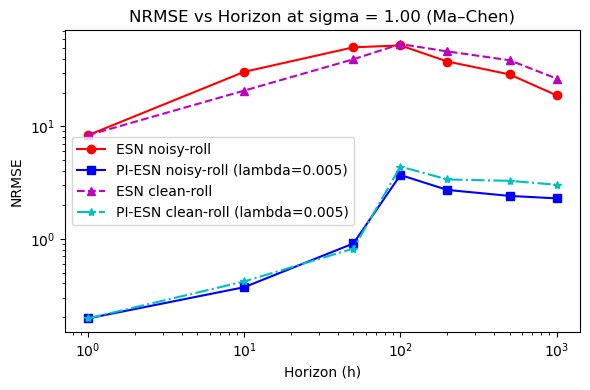

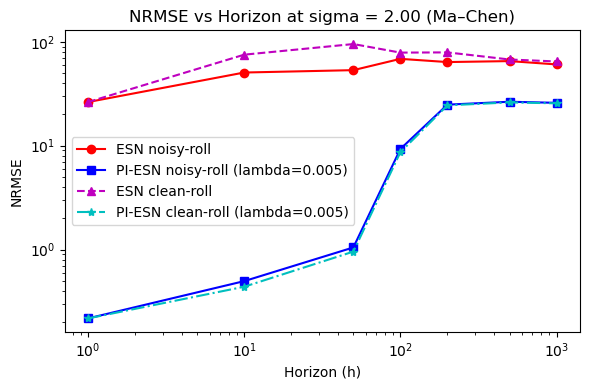

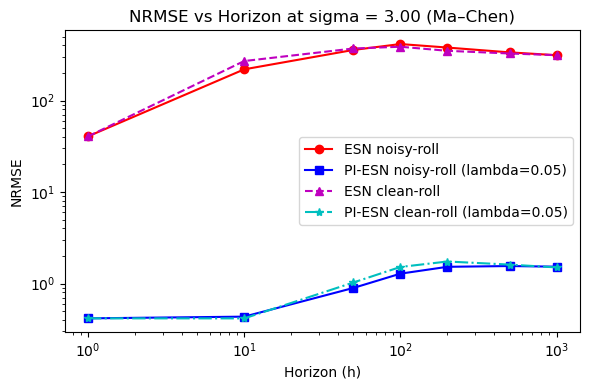

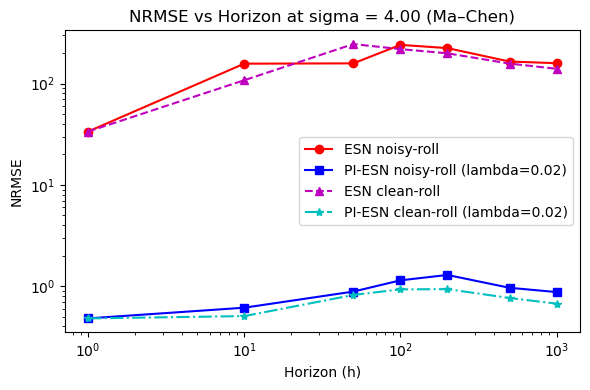

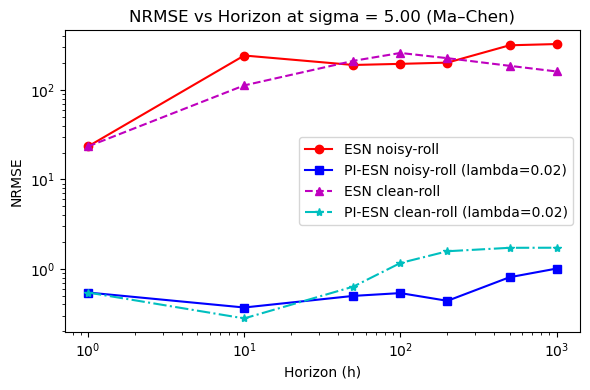

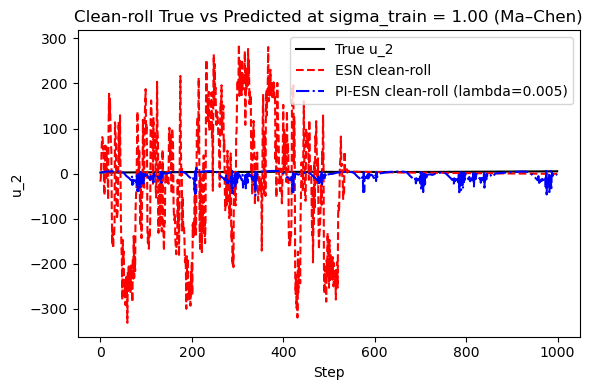

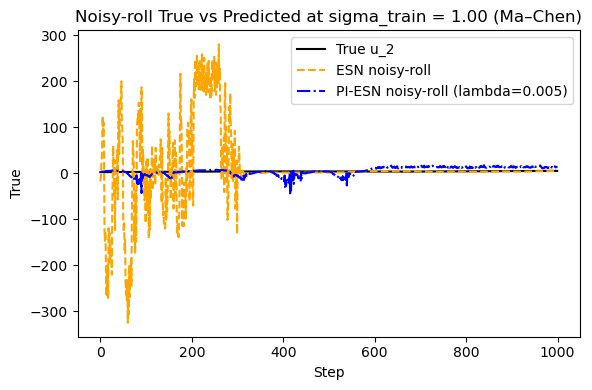

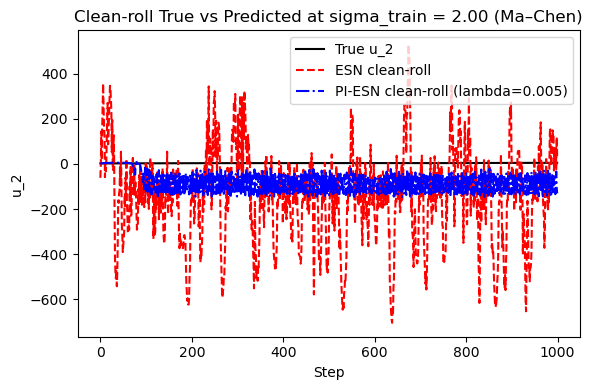

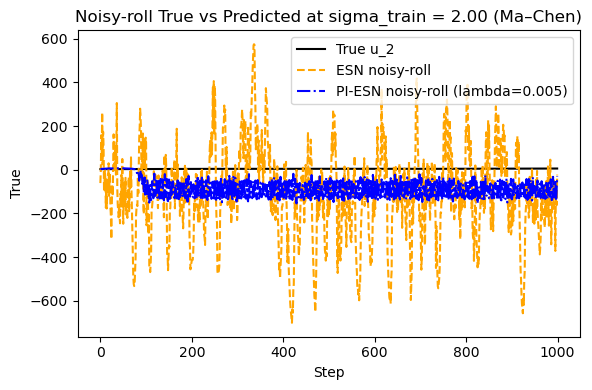

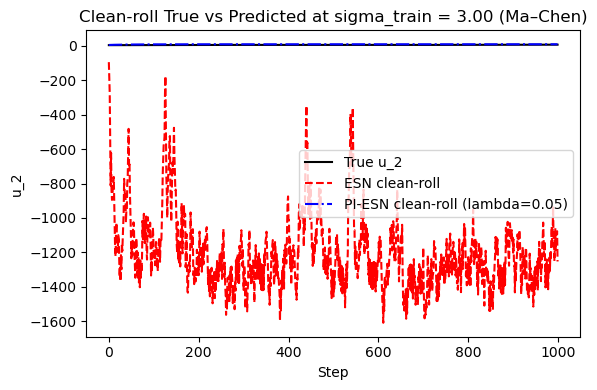

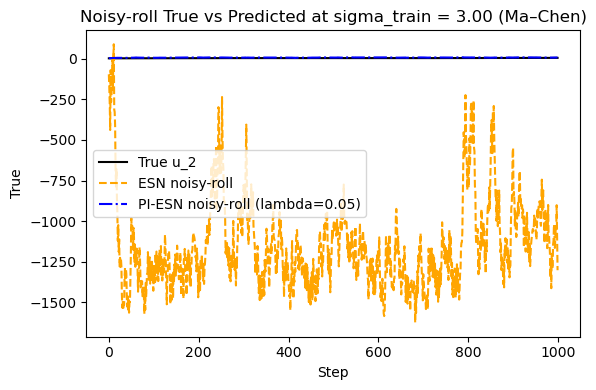

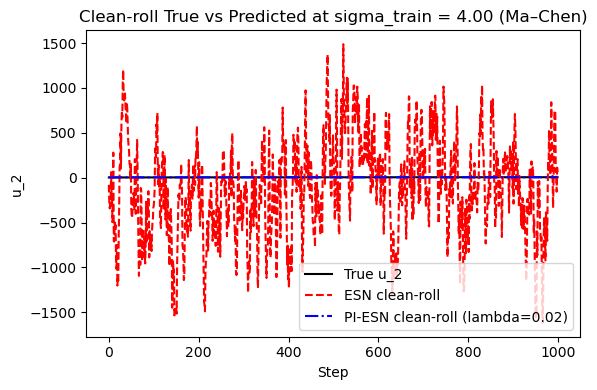

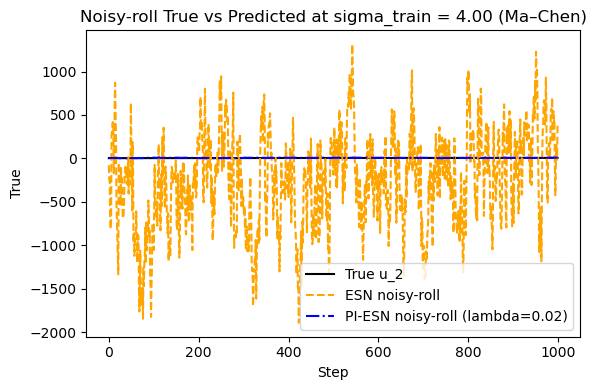

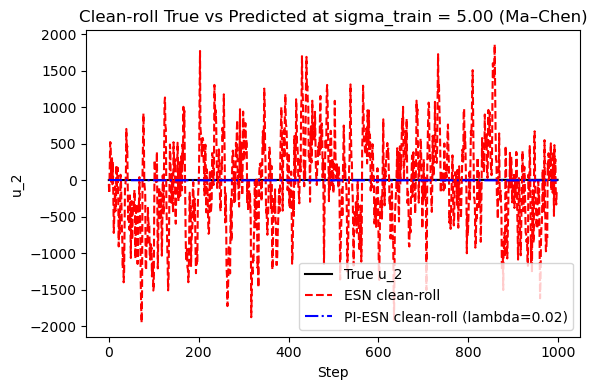

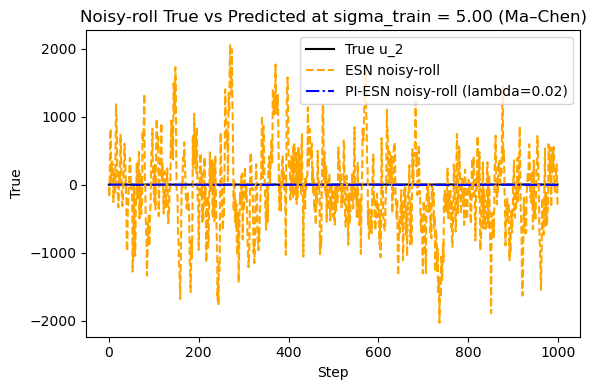

In [31]:
best = {
    'res_size':   960,
    'rho':        0.10009762488352285,
    'sparsity':   0.014635603653829913,
    'in_scale':   0.10012333896882074,
    'alpha':      0.22320271024144345,
    'ridge_reg':  8.160533191764472e-05,
    'topo':       'random',
    'lambda_data': 0.736548536623833,
    'lambda_phys': 0.13714180027119693,
    'horizon':    7
}

SEED, dt, length = 42, 0.01, 6000

# Parametri Ma–Chen
alpha_mc = 3.0
beta_mc  = 0.1
gamma_mc = 1.0

# Livelli di rumore “equivalenti” a quelli usati per Lorenz
noise_levels = [1, 2, 3, 4, 5]

horizons        = [1, 10, 50, 100, 200, 500, 1000]
lambda_phys_grid = [0.005, 0.01, 0.02, 0.05]

def roll(model, u0, steps, sigma=0, rng=None):
    y = model.predict(u0.reshape(1, -1), continuation=False)[0]
    out = [y.copy()]
    for _ in range(steps - 1):
        if sigma:
            y_in = y + rng.normal(scale=sigma, size=y.shape)
        else:
            y_in = y
        y = model.predict(y_in.reshape(1, -1), continuation=True)[0]
        out.append(y.copy())
    return np.stack(out)[:, 1]

def nrmse(true, pred):
    return norm(true - pred) / norm(true)


np.random.seed(SEED)
_, traj_clean = generate_machen(
    length=length, dt=dt,
    alpha=alpha_mc, beta=beta_mc, gamma=gamma_mc,
    noise=0.0, seed=SEED
)
U_clean, Y_clean = traj_clean[:-1], traj_clean[1:]
(_, _), (_, _), (u_te, y_te) = split_train_val_test(
    U_clean, Y_clean, train_frac=0.6, val_frac=0.2
)
y_true = y_te[:, 1]

rows = []

for sigma in noise_levels:
    np.random.seed(SEED)
    _, traj_noisy = generate_machen(
        length=length, dt=dt,
        alpha=alpha_mc, beta=beta_mc, gamma=gamma_mc,
        noise=sigma, seed=SEED
    )
    U_noisy, Y_noisy = traj_noisy[:-1], traj_noisy[1:]
    (u_tr, y_tr), (_, _), _ = split_train_val_test(
        U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2
    )

    # Alleno ESN puro su dati rumorosi
    esn = ESN(
        in_size         = 3,
        res_size        = best['res_size'],
        out_size        = 3,
        spectral_radius = best['rho'],
        sparsity         = best['sparsity'],
        input_scaling   = best['in_scale'],
        leak_rate       = best['alpha'],
        ridge_reg        = best['ridge_reg'],
        seed            = SEED,
        topology         = best['topo']
    )
    esn.fit(u_tr, y_tr, washout=100)
    rng_esn = np.random.default_rng(int(1e6 * sigma) + SEED)

    for lp in lambda_phys_grid:
        pi = PIESN(
            in_size          = 3,
            res_size         = best['res_size'],
            out_size         = 3,
            spectral_radius  = best['rho'],
            sparsity         = best['sparsity'],
            input_scaling    = best['in_scale'],
            leak_rate        = best['alpha'],
            ridge_reg        = best['ridge_reg'],
            seed             = SEED,
            topology         = best['topo'],
            lambda_data      = best['lambda_data'],
            lambda_phys      = lp,
            ode_func         = partial(machen_rhs, alpha=alpha_mc, beta=beta_mc, gamma=gamma_mc),
            delta_t          = dt,
            phys_horizon     = best['horizon'],
            full_closed_loop = True,
            curriculum       = False
        )
        pi.fit_physics(u_tr, y_tr, washout=100)
        rng_pi = np.random.default_rng(int(1e6 * sigma) + SEED + int(lp * 1e3))

        esn_noisy = roll(esn, u_te[0], max(horizons), sigma, rng_esn)
        pi_noisy  = roll(pi,  u_te[0], max(horizons), sigma, rng_pi)
        esn_clean = roll(esn, u_te[0], max(horizons))
        pi_clean  = roll(pi,  u_te[0], max(horizons))

        for h in horizons:
            rows.append({
                'sigma':       sigma,
                'lambda_phys': lp,
                'h':           h,
                'ESN_noisy':   nrmse(y_true[:h], esn_noisy[:h]),
                'PI_noisy':    nrmse(y_true[:h], pi_noisy[:h]),
                'ESN_clean':   nrmse(y_true[:h], esn_clean[:h]),
                'PI_clean':    nrmse(y_true[:h], pi_clean[:h])
            })

df = pd.DataFrame(rows)

best_lps = (
    df[df['h'] == 10]
    .groupby('sigma')
    .apply(lambda d: d.loc[d['PI_noisy'].idxmin(), 'lambda_phys'])
    .to_dict()
)

for sigma in noise_levels:
    lp_best = best_lps[sigma]
    subset = df[(df['sigma'] == sigma) & (df['lambda_phys'] == lp_best)]
    plt.figure(figsize=(6, 4))
    plt.plot(horizons, subset['ESN_noisy'], 'r-o', label='ESN noisy-roll')
    plt.plot(horizons, subset['PI_noisy'],  'b-s', label=f'PI-ESN noisy-roll (lambda={lp_best})')
    plt.plot(horizons, subset['ESN_clean'],'m--^', label='ESN clean-roll')
    plt.plot(horizons, subset['PI_clean'], 'c-.*', label=f'PI-ESN clean-roll (lambda={lp_best})')
    plt.xlabel('Horizon (h)')
    plt.ylabel('NRMSE')
    plt.title(f'NRMSE vs Horizon at sigma = {sigma:.2f} (Ma–Chen)')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

hmax = max(horizons)
for sigma in noise_levels:
    lp_best = best_lps[sigma]

    np.random.seed(SEED)
    _, traj_noisy = generate_machen(
        length=length, dt=dt, noise=sigma,
        alpha=alpha_mc, beta=beta_mc, gamma=gamma_mc,
        seed=SEED
    )
    U_noisy, Y_noisy = traj_noisy[:-1], traj_noisy[1:]
    (u_tr, y_tr), (_, _), _ = split_train_val_test(U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2)

    esn = ESN(
        in_size         = 3,
        res_size        = best['res_size'],
        out_size        = 3,
        spectral_radius = best['rho'],
        sparsity         = best['sparsity'],
        input_scaling   = best['in_scale'],
        leak_rate        = best['alpha'],
        ridge_reg        = best['ridge_reg'],
        seed            = SEED,
        topology         = best['topo']
    )
    esn.fit(u_tr, y_tr, washout=100)
    rng_esn = np.random.default_rng(int(1e6 * sigma) + SEED)

    pi = PIESN(
        in_size         = 3,
        res_size        = best['res_size'],
        out_size        = 3,
        spectral_radius = best['rho'],
        sparsity         = best['sparsity'],
        input_scaling   = best['in_scale'],
        leak_rate        = best['alpha'],
        ridge_reg        = best['ridge_reg'],
        seed            = SEED,
        topology         = best['topo'],
        lambda_data     = best['lambda_data'],
        lambda_phys     = lp_best,
        ode_func        = partial(machen_rhs, alpha=alpha_mc, beta=beta_mc, gamma=gamma_mc),
        delta_t         = dt,
        phys_horizon    = best['horizon'],
        full_closed_loop= True,
        curriculum      = False
    )
    pi.fit_physics(u_tr, y_tr, washout=100)
    rng_pi = np.random.default_rng(int(1e6 * sigma) + SEED + int(lp_best * 1e3))

    esn_clean = roll(esn, u_te[0], hmax, sigma=0, rng=None)
    pi_clean  = roll(pi,  u_te[0], hmax, sigma=0, rng=None)

    esn_noisy = roll(esn, u_te[0], hmax, sigma, rng_esn)
    pi_noisy  = roll(pi,  u_te[0], hmax, sigma, rng_pi)

    idx = np.arange(hmax)

    plt.figure(figsize=(6, 4))
    plt.plot(idx, y_true[:hmax], 'k-', label='True u_2')
    plt.plot(idx, esn_clean[:hmax], 'r--', label='ESN clean-roll')
    plt.plot(idx, pi_clean[:hmax],  'b-.', label=f'PI-ESN clean-roll (lambda={lp_best})')
    plt.xlabel('Step')
    plt.ylabel('u_2')
    plt.title(f'Clean-roll True vs Predicted at sigma_train = {sigma:.2f} (Ma–Chen)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(idx, y_true[:hmax], 'k-', label='True u_2')
    plt.plot(idx, esn_noisy[:hmax],'--', color='orange', label='ESN noisy-roll')
    plt.plot(idx, pi_noisy[:hmax],  'b-.', label=f'PI-ESN noisy-roll (lambda={lp_best})')
    plt.xlabel('Step')
    plt.ylabel('True')
    plt.title(f'Noisy-roll True vs Predicted at sigma_train = {sigma:.2f} (Ma–Chen)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
summary_rows = []
for sigma, lp_best in best_lps.items():
    subset = df[(df['sigma'] == sigma) & (df['lambda_phys'] == lp_best)]
    for _, row in subset.iterrows():
        summary_rows.append({
            'sigma': sigma,
            'h': int(row['h']),
            'lambda_phys': lp_best,
            'ESN_clean': row['ESN_clean'],
            'PI_clean': row['PI_clean'],
            'ESN_noisy': row['ESN_noisy'],
            'PI_noisy': row['PI_noisy']
        })

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values(by=['sigma', 'h']).reset_index(drop=True)


print("---------- Riepilogo NRMSE per ciascun sigma e h (usando lambda_phys ottimale) ----------\n")
print(df_summary.to_string(index=False, float_format="{:.3f}".format))

---------- Riepilogo NRMSE per ciascun sigma e h (usando lambda_phys ottimale) ----------

 sigma    h  lambda_phys  ESN_clean  PI_clean  ESN_noisy  PI_noisy
     1    1        0.005      8.340     0.196      8.340     0.196
     1   10        0.005     20.793     0.417     30.547     0.371
     1   50        0.005     39.518     0.818     50.461     0.908
     1  100        0.005     53.975     4.386     52.494     3.689
     1  200        0.005     46.398     3.368     37.743     2.717
     1  500        0.005     38.760     3.275     28.982     2.405
     1 1000        0.005     26.603     3.022     18.892     2.286
     2    1        0.005     26.273     0.217     26.273     0.217
     2   10        0.005     75.129     0.438     50.573     0.496
     2   50        0.005     95.072     0.954     53.307     1.047
     2  100        0.005     78.639     8.653     68.472     9.284
     2  200        0.005     79.025    24.439     63.767    24.811
     2  500        0.005     67.506   

In [37]:
# --- 1) Keep your existing imports and helper functions ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

best = {
    'res_size':   960,
    'rho':        0.10009762488352285,
    'sparsity':   0.014635603653829913,
    'in_scale':   0.10012333896882074,
    'alpha':      0.22320271024144345,
    'ridge_reg':  8.160533191764472e-05,
    'topo':       'random',
    'λ_data': 0.736548536623833,
    'lambda_phys': 0.13714180027119693,
    'horizon':    7
}

def compute_nrmse(true, pred):
    return np.linalg.norm(true - pred) / np.linalg.norm(true)

def forecast_horizon(true_seq, pred_seq, threshold=0.2):
    L = len(true_seq)
    norm_true = np.linalg.norm(true_seq)
    if norm_true == 0:
        return 0
    for k in range(1, L + 1):
        err = np.linalg.norm(true_seq[:k] - pred_seq[:k]) / norm_true
        if err >= threshold:
            return k - 1
    return L


SEED, dt, length = 42, 0.01, 6000
noise_levels = [1, 2, 3, 4, 5]
horizons = [1, 10, 50, 100, 200, 500, 1000]
lambda_phys_grid = [0.005, 0.01, 0.02, 0.05]

def roll(model, u0, steps, sigma=0, rng=None):
    y = model.predict(u0.reshape(1, -1), continuation=False)[0]
    out = [y.copy()]
    for _ in range(steps - 1):
        if sigma:
            y_in = y + rng.normal(scale=sigma, size=y.shape)
        else:
            y_in = y
        y = model.predict(y_in.reshape(1, -1), continuation=True)[0]
        out.append(y.copy())
    return np.stack(out)[:, 1]  # second coordinate (y‐component)

# Generate a single clean Lorenz trajectory for testing
np.random.seed(SEED)
_, traj_clean = generate_machen(length=length, dt=dt, noise=0.0)
U_clean, Y_clean = traj_clean[:-1], traj_clean[1:]
(_, _), (_, _), (u_te, y_te) = split_train_val_test(U_clean, Y_clean, train_frac=0.6, val_frac=0.2)
y_true = y_te[:, 1]  # “ground‐truth” y‐component of test set

# --- 3) Loop over noise levels, train ESN & PI-ESN, collect horizons ---
results = []  # will store rows of {sigma, model_type, horizon}

for sigma in noise_levels:
    # Generate a noisy training trajectory
    np.random.seed(SEED)
    _, traj_noisy = generate_machen(length=length, dt=dt, noise=sigma)
    U_noisy, Y_noisy = traj_noisy[:-1], traj_noisy[1:]
    (u_tr, y_tr), (_, _), _ = split_train_val_test(U_noisy, Y_noisy, train_frac=0.6, val_frac=0.2)

    # Train plain ESN
    esn = ESN(
        in_size=3,
        res_size=best['res_size'],
        out_size=3,
        spectral_radius=best['rho'],
        sparsity=best['sparsity'],
        input_scaling=best['in_scale'],
        leak_rate=best['alpha'],
        ridge_reg=best['ridge_reg'],
        seed=SEED,
        topology=best['topo']
    )
    esn.fit(u_tr, y_tr, washout=100)
    rng_esn = np.random.default_rng(int(1e6 * sigma) + SEED)

    # Find the best lambda_phys for PI‐ESN (as you did before)
    best_lp_for_sigma = best_lps[sigma]

    # Train PI-ESN with that lambda_phys
    pi = PIESN(
        in_size         = 3,
        res_size        = best['res_size'],
        out_size        = 3,
        spectral_radius = best['rho'],
        sparsity        = best['sparsity'],
        input_scaling   = best['in_scale'],
        leak_rate       = best['alpha'],
        ridge_reg       = best['ridge_reg'],
        seed            = SEED,
        topology        = best['topo'],
        lambda_data     = best['λ_data'],
        lambda_phys     = best_lp_for_sigma,
        ode_func        = machen_rhs,
        delta_t         = dt,
        phys_horizon    = best['horizon'],
        full_closed_loop= True,
        curriculum      = False
    )
    pi.fit_physics(u_tr, y_tr, washout=100)
    rng_pi = np.random.default_rng(int(1e6 * sigma) + SEED + int(best_lp_for_sigma * 1e3))

    # Roll out to hmax steps for both models
    hmax = max(horizons)
    esn_clean_preds = roll(esn, u_te[0], hmax, sigma=0, rng=None)
    esn_noisy_preds = roll(esn, u_te[0], hmax, sigma, rng_esn)
    pi_clean_preds  = roll(pi,  u_te[0], hmax, sigma=0, rng=None)
    pi_noisy_preds  = roll(pi,  u_te[0], hmax, sigma, rng_pi)

    # Compute forecast horizons for each of the 4 cases, using threshold=1.0
    h_esn_clean = forecast_horizon(y_true[:hmax], esn_clean_preds, threshold=1.0)
    h_esn_noisy = forecast_horizon(y_true[:hmax], esn_noisy_preds, threshold=1.0)
    h_pi_clean  = forecast_horizon(y_true[:hmax], pi_clean_preds,  threshold=1.0)
    h_pi_noisy  = forecast_horizon(y_true[:hmax], pi_noisy_preds,  threshold=1.0)

    # Store in results
    results.append({
        'sigma': sigma,
        'model': 'ESN_clean',
        'horizon': h_esn_clean
    })
    results.append({
        'sigma': sigma,
        'model': 'ESN_noisy',
        'horizon': h_esn_noisy
    })
    results.append({
        'sigma': sigma,
        'model': 'PI_clean',
        'horizon': h_pi_clean
    })
    results.append({
        'sigma': sigma,
        'model': 'PI_noisy',
        'horizon': h_pi_noisy
    })

# Convert to DataFrame and print
horizons_df = pd.DataFrame(results)
print(horizons_df)

    sigma      model  horizon
0       1  ESN_clean        5
1       1  ESN_noisy        5
2       1   PI_clean      106
3       1   PI_noisy      297
4       2  ESN_clean        2
5       2  ESN_noisy        2
6       2   PI_clean       93
7       2   PI_noisy       93
8       3  ESN_clean        1
9       3  ESN_noisy        1
10      3   PI_clean     1000
11      3   PI_noisy     1000
12      4  ESN_clean        1
13      4  ESN_noisy        1
14      4   PI_clean     1000
15      4   PI_noisy     1000
16      5  ESN_clean        1
17      5  ESN_noisy        1
18      5   PI_clean      615
19      5   PI_noisy      983


---------- Riepilogo NRMSE per ciascun sigma e h (usando lambda_phys ottimale) ----------

 sigma    h  lambda_phys  ESN_clean  PI_clean  ESN_noisy  PI_noisy
 0.018    1        0.005      1.968     0.406      1.968     0.406
 0.018   10        0.005      1.555     0.385      1.554     0.386
 0.018   50        0.005      1.328     0.443      1.328     0.444
 0.018  100        0.005      1.199     0.512      1.198     0.513
 0.018  200        0.005      1.011     0.591      1.009     0.608
 0.018  500        0.005      0.670     0.439      0.670     0.473
 0.018 1000        0.005      0.453     0.393      0.478     0.409
 0.438    1        0.005      0.022     0.243      0.022     0.243
 0.438   10        0.005      0.799     0.377      0.794     0.359
 0.438   50        0.005      0.763     0.927      0.747     0.832
 0.438  100        0.005      0.702     0.788      0.716     0.694
 0.438  200        0.005      0.606     0.793      0.663     0.699
 0.438  500        0.005      0.398     0.809      0.427     0.727
 0.438 1000        0.005      0.295     0.820      0.379     0.731
 1.752    1        0.005     22.179     0.183     22.179     0.183
 1.752   10        0.005     36.177     0.430     19.312     0.455
 1.752   50        0.005     64.973     0.913     55.793     0.764
 1.752  100        0.005     52.792     3.035     51.952    15.851
 1.752  200        0.005     47.589    12.922     46.519    20.594
 1.752  500        0.005     40.551    17.895     36.369    20.147
 1.752 1000        0.005     37.221    17.550     33.398    19.326
 7.006    1        0.020      6.407     0.681      6.407     0.681
 7.006   10        0.020      2.237     0.454      2.766     0.606
 7.006   50        0.020      4.368     1.965    215.061     1.710
 7.006  100        0.020     85.379     2.483    236.069     2.556
 7.006  200        0.020    186.953     2.637    218.666     2.870
 7.006  500        0.020    205.453     2.527    213.157     2.384
 7.006 1000        0.020    201.363     2.445    196.586     2.173
28.026    1        0.005      1.406     3.742      1.406     3.742
28.026   10        0.005      3.311     1.949    153.249     2.950
28.026   50        0.005      5.463     2.780    185.255     2.824
28.026  100        0.005      6.119     3.118    212.618     4.025
28.026  200        0.005      4.973     3.103    207.479     3.742
28.026  500        0.005      4.039     2.873    200.425     3.216
28.026 1000        0.005     74.940     2.750    185.701     3.073

/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_34240/204442720.py:64: RuntimeWarning: divide by zero encountered in matmul
  XtX = X.T @ X
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_34240/204442720.py:64: RuntimeWarning: overflow encountered in matmul
  XtX = X.T @ X
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_34240/204442720.py:64: RuntimeWarning: invalid value encountered in matmul
  XtX = X.T @ X
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_34240/204442720.py:66: RuntimeWarning: divide by zero encountered in matmul
  W_ridge_esn = np.linalg.solve(XtX + reg, X.T @ targets)  # (N,)
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_34240/204442720.py:66: RuntimeWarning: overflow encountered in matmul
  W_ridge_esn = np.linalg.solve(XtX + reg, X.T @ targets)  # (N,)
/var/folders/5k/gpnrmhzx1_g61567v3vr7ysh0000gn/T/ipykernel_34240/204442720.py:66: RuntimeWarning: invalid value encountered in matmul
  W_ridge_esn = np.linal

Total linear MC (ESN) ≈ 4.61  (upper bound = 960)


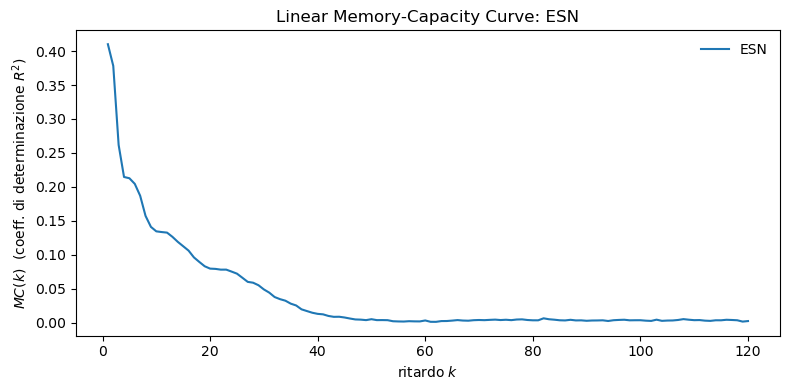

In [34]:
best = {
    'res_size':   960,
    'rho':        0.10009762488352285,
    'sparsity':   0.014635603653829913,
    'in_scale':   0.10012333896882074,
    'alpha':      0.22320271024144345,
    'ridge_reg':  8.160533191764472e-05,
    'topo':       'random'
}

SEED    = 42
in_size = 1
out_size= 1
N       = best['res_size']


esn = ESN(
    in_size         = in_size,
    res_size        = N,
    out_size        = out_size,
    spectral_radius = best['rho'],
    sparsity        = best['sparsity'],
    input_scaling   = best['in_scale'],
    leak_rate       = best['alpha'],
    ridge_reg       = best['ridge_reg'],
    seed            = SEED,
    topology        = best['topo']
)


T_warm = 200
T_eval = 4000
rng = np.random.default_rng(SEED)
u_seq = rng.choice([-1.0, +1.0], size=T_warm + T_eval)


esn.fit(
    u_seq[:T_warm].reshape(-1,1),
    u_seq[:T_warm].reshape(-1,1),
    washout=0
)


states_esn   = np.zeros((T_eval, N))
x_esn = np.zeros(N)

for t in range(T_eval):
    u_in = np.array([u_seq[T_warm + t]])
    x_esn   = esn._update(x_esn, u_in)
    states_esn[t]   = x_esn


max_k     = 120
eps_ridge = 1e-8

R2_esn = []

for k in range(1, max_k + 1):
   
    targets = u_seq[T_warm - k : T_warm + T_eval - k]  # lunghezza = T_eval

    # Ridge closed‐form: X = states_esn (T_eval, N)
    X = states_esn
    XtX = X.T @ X
    reg = eps_ridge * np.eye(N)
    W_ridge_esn = np.linalg.solve(XtX + reg, X.T @ targets)  # (N,)
    pred_esn = X @ W_ridge_esn

    var_t   = np.var(targets)
    R2_k_esn = 0.0 if var_t == 0 else 1 - np.var(targets - pred_esn) / var_t
    R2_esn.append(R2_k_esn)

MC_total_esn   = np.sum(R2_esn)

print(f"Total linear MC (ESN) ≈ {MC_total_esn:.2f}  (upper bound = {N})")


ks = np.arange(1, max_k + 1)

plt.figure(figsize=(8,4))
plt.plot(ks, R2_esn,   label="ESN",   lw=1.5)
plt.xlabel("ritardo $k$")
plt.ylabel("$MC(k)$  (coeff. di determinazione $R^2$)")
plt.title("Linear Memory‐Capacity Curve: ESN")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

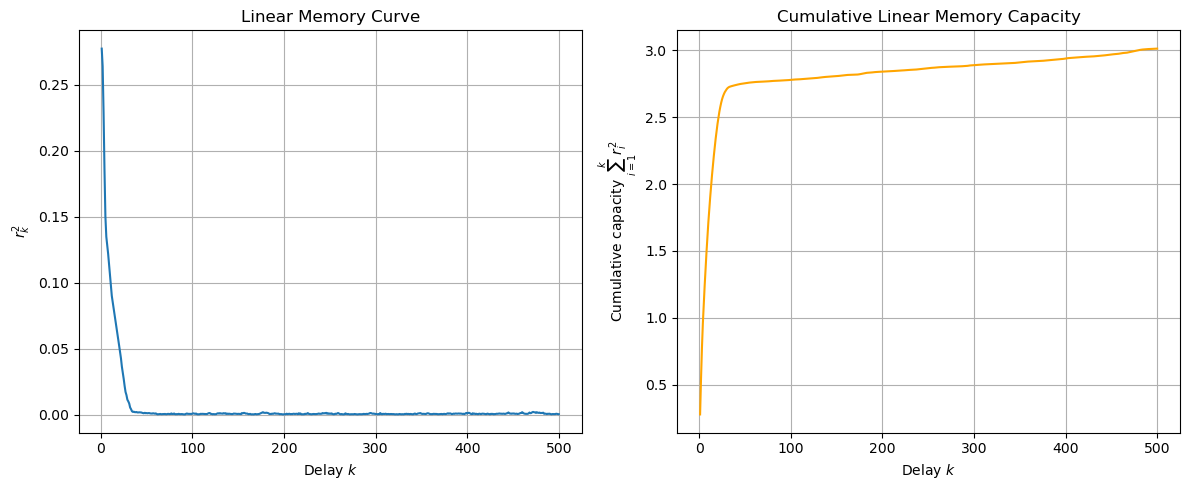

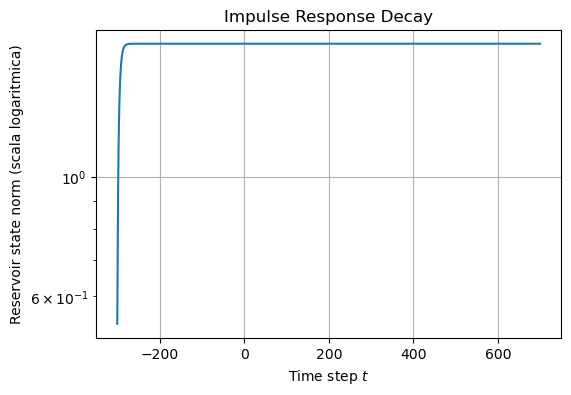

Ritardo k* (r_k^2 < 0.01): 30
Capacità lineare totale (∑ r_k^2): 3.0127
Capacità normalizzata (MC / N): 0.003138
Costante di decadimento stimata τ: -106.45 time steps


In [38]:
def compute_memory_curve(esn, delay_max=500, washout=100, input_length=10000):
    rng = np.random.default_rng(0)
    # Sequenza di input casuale u(t) ∈ [-1,1]
    U = rng.uniform(-1, 1, size=(input_length, esn.in_size))
    
    # Colleziono stati dopo washout
    states = np.zeros((input_length - washout, esn.res_size))
    x = np.zeros(esn.res_size)
    for t in range(input_length):
        u = np.atleast_1d(U[t])
        x = esn._update(x, u)
        if t >= washout:
            states[t - washout] = x
    U_trim = U[washout:]
    
    # Calcolo r_k^2 per ogni ritardo k
    r2 = np.zeros(delay_max)
    for k in range(1, delay_max + 1):
        if k >= len(U_trim):
            break
        X_k = states[k:]            # (T - washout - k, res_size)
        target = U_trim[:-k, 0]     # Ricostruiamo prima componente di U
        # Disegno la matrice di progetto X_design = [1, x(t)]
        X_design = np.hstack((np.ones((X_k.shape[0], 1)), X_k))
        # Ridge closed-form: w = (X^T X + α I)^{-1} X^T y
        alpha = esn.ridge_reg
        XtX = X_design.T.dot(X_design)
        reg = alpha * np.eye(XtX.shape[0])
        w = np.linalg.inv(XtX + reg).dot(X_design.T).dot(target)
        preds = X_design.dot(w)
        r, _ = pearsonr(preds, target)
        r2[k-1] = r**2
    return r2

def plot_memory_curve(r2):
    k = np.arange(1, len(r2) + 1)
    cum_capacity = np.cumsum(r2)
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: r_k^2 vs k
    plt.subplot(1, 2, 1)
    plt.plot(k, r2, label=r"$r_k^2$")
    plt.xlabel("Delay $k$")
    plt.ylabel(r"$r_k^2$")
    plt.title("Linear Memory Curve")
    plt.grid(True)
    
    # Plot 2: capacità cumulativa vs k
    plt.subplot(1, 2, 2)
    plt.plot(k, cum_capacity, label="Cumulative capacity", color='orange')
    plt.xlabel("Delay $k$")
    plt.ylabel(r"Cumulative capacity $\sum_{i=1}^k r_i^2$")
    plt.title("Cumulative Linear Memory Capacity")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def compute_impulse_response(esn, time_steps=1000):

    U = np.zeros((time_steps, esn.in_size))
    U[0] = np.ones(esn.in_size)
    
    x = np.zeros(esn.res_size)
    norms = np.zeros(time_steps)
    for t in range(time_steps):
        u = U[t]
        x = esn._update(x, u)
        norms[t] = np.linalg.norm(x)
    return norms

def plot_impulse_response(norms):
    t = np.arange(len(norms))
    plt.figure(figsize=(6, 4))
    plt.semilogy(t-300, norms, label=r"$\|x(t)\|$")
    plt.xlabel("Time step $t$")
    plt.ylabel(r"Reservoir state norm (scala logaritmica)")
    plt.title("Impulse Response Decay")
    plt.grid(True)
    plt.show()

best_params  = {
    'res_size':   960,
    'rho':        0.10009762488352285,
    'sparsity':   0.014635603653829913,
    'in_scale':   0.10012333896882074,
    'alpha':      0.22320271024144345,
    'ridge_reg':  8.160533191764472e-05,
    'topo':       'random'
}

esn = ESN(
    in_size=1,
    res_size=best_params['res_size'],
    out_size=1,
    spectral_radius=best_params['rho'],
    sparsity=best_params['sparsity'],
    input_scaling=best_params['in_scale'],
    leak_rate=best_params['alpha'],
    ridge_reg=best_params['ridge_reg'],
    topology=best_params['topo'],
    seed=42
)


r2_curve = compute_memory_curve(esn, delay_max=500, washout=100, input_length=10000)


plot_memory_curve(r2_curve)


norms = compute_impulse_response(esn, time_steps=1000)
plot_impulse_response(norms)

epsilon = 0.01
indices = np.where(r2_curve < epsilon)[0]
k_star = indices[0] + 1 if len(indices) > 0 else None

total_MC = np.sum(r2_curve)
normalized_MC = total_MC / esn.res_size

T_fit = 50
t_fit = np.arange(T_fit)
y_fit = norms[:T_fit]
coeffs = np.polyfit(t_fit, np.log(y_fit), 1)
q, lnA = coeffs
tau_est = -1.0 / q
print(f"Ritardo k* (r_k^2 < {epsilon}): {k_star}")
print(f"Capacità lineare totale (∑ r_k^2): {total_MC:.4f}")
print(f"Capacità normalizzata (MC / N): {normalized_MC:.6f}")
print(f"Costante di decadimento stimata τ: {tau_est:.2f} time steps")

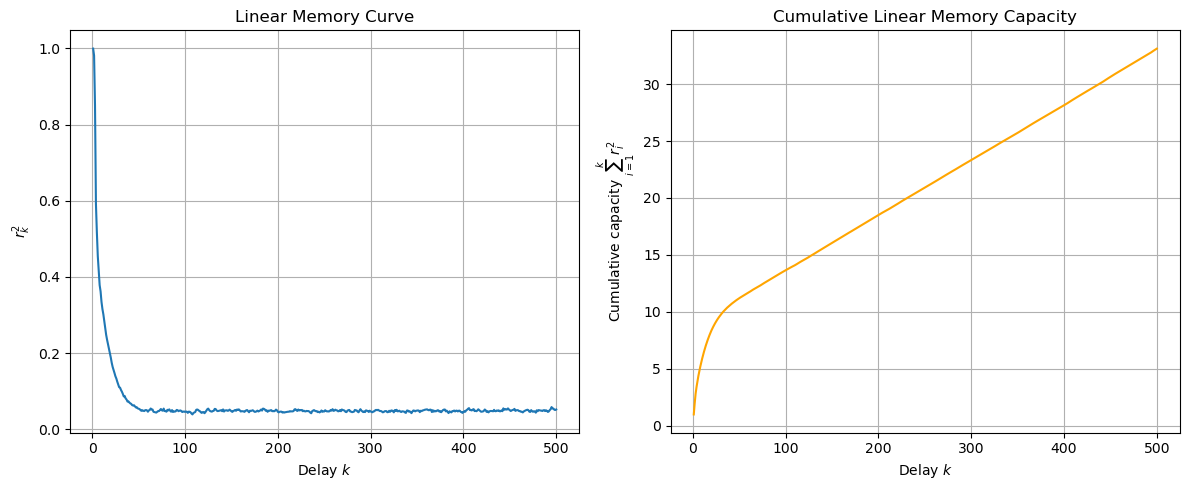

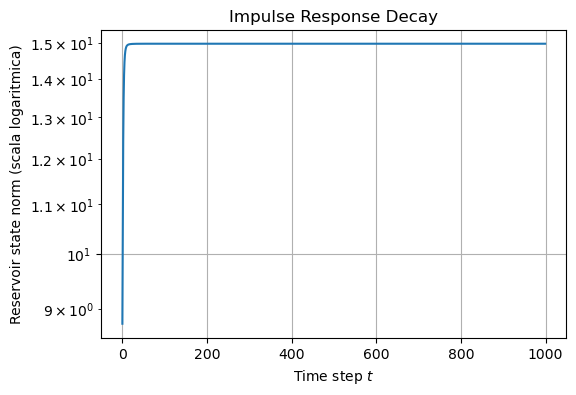

Ritardo k* (r_k^2 < 0.01): None
Capacità lineare totale (∑ r_k^2): 33.1090
Capacità normalizzata (MC / N): 0.034489
Costante di decadimento stimata τ: -339.23 time steps


In [36]:
best_params  = {
    'res_size':   960,
    'rho':        0.99,
    'sparsity':   1,
    'in_scale':   0.9,
    'alpha':      0.5,
    'ridge_reg':  8.160533191764472e-05,
    'topo':       'double_cycle'
}

esn = ESN(
    in_size=1,
    res_size=best_params['res_size'],
    out_size=1,
    spectral_radius=best_params['rho'],
    sparsity=best_params['sparsity'],
    input_scaling=best_params['in_scale'],
    leak_rate=best_params['alpha'],
    ridge_reg=best_params['ridge_reg'],
    topology=best_params['topo'],
    seed=42
)

r2_curve = compute_memory_curve(esn, delay_max=500, washout=100, input_length=10000)

plot_memory_curve(r2_curve)

norms = compute_impulse_response(esn, time_steps=1000)
plot_impulse_response(norms)

epsilon = 0.01
indices = np.where(r2_curve < epsilon)[0]
k_star = indices[0] + 1 if len(indices) > 0 else None

total_MC = np.sum(r2_curve)
normalized_MC = total_MC / esn.res_size

T_fit = 50
t_fit = np.arange(T_fit)
y_fit = norms[:T_fit]
coeffs = np.polyfit(t_fit, np.log(y_fit), 1)
q, lnA = coeffs
tau_est = -1.0 / q
print(f"Ritardo k* (r_k^2 < {epsilon}): {k_star}")
print(f"Capacità lineare totale (∑ r_k^2): {total_MC:.4f}")
print(f"Capacità normalizzata (MC / N): {normalized_MC:.6f}")
print(f"Costante di decadimento stimata τ: {tau_est:.2f} time steps")